# Getting Started

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder

from aif360.sklearn.preprocessing import Reweighing, ReweighingMeta
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta
from aif360.sklearn.datasets import fetch_adult
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr
from aif360.sklearn.metrics import generalized_fnr, difference

## Loading data

Datasets are formatted as separate `X` (# samples x # features) and `y` (# samples x # labels) DataFrames. The index of each DataFrame contains protected attribute values per sample. Datasets may also load a `sample_weight` object to be used with certain algorithms/metrics. All of this makes it so that aif360 is compatible with scikit-learn objects.

For example, we can easily load the Adult dataset from UCI with the following line:

In [2]:
X, y, sample_weight = fetch_adult()
X.head()

age  workclass     education  education-num  \
race      sex                                                  
Non-white Male  25.0    Private          11th            7.0   
White     Male  38.0    Private       HS-grad            9.0   
          Male  28.0  Local-gov    Assoc-acdm           12.0   
Non-white Male  44.0    Private  Some-college           10.0   
White     Male  34.0    Private          10th            6.0   

                    marital-status         occupation   relationship   race  \
race      sex                                                                 
Non-white Male       Never-married  Machine-op-inspct      Own-child  Black   
White     Male  Married-civ-spouse    Farming-fishing        Husband  White   
          Male  Married-civ-spouse    Protective-serv        Husband  White   
Non-white Male  Married-civ-spouse  Machine-op-inspct        Husband  Black   
White     Male       Never-married      Other-service  Not-in-family  White   

                 sex  capital-gain  capital-loss  hours-per-week  \
race      sex                                                      
Non-white Male  Male           0.0           0.0            40.0   
White     Male  Male           0.0           0.0            50.0   
          Male  Male           0.0           0.0            40.0   
Non-white Male  Male        7688.0           0.0            40.0   
White     Male  Male           0.0           0.0            30.0   

               native-country  
race      sex                  
Non-white Male  United-States  
White     Male  United-States  
          Male  United-States  
Non-white Male  United-States  
White     Male  United-States

We can then map the protected attributes to integers,

In [3]:
X.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)

and the target classes to 0/1,

In [4]:
y = pd.Series(y.factorize(sort=True)[0], index=y.index)

split the dataset,

In [23]:
(X_train, X_test,
 y_train, y_test) = train_test_split(X, y, train_size=0.7, random_state=1234567)

and finally, one-hot encode the categorical features:

In [24]:
ohe = make_column_transformer(
        (OneHotEncoder(sparse=False), X_train.dtypes == 'category'),
        remainder='passthrough', verbose_feature_names_out=False)
X_train  = pd.DataFrame(ohe.fit_transform(X_train), columns=ohe.get_feature_names_out(), index=X_train.index)
X_test = pd.DataFrame(ohe.transform(X_test), columns=ohe.get_feature_names_out(), index=X_test.index)

X_train.head()

workclass_Federal-gov  workclass_Local-gov  workclass_Private  \
race sex                                                                  
1    1                      0.0                  0.0                0.0   
     0                      0.0                  0.0                0.0   
     1                      0.0                  0.0                1.0   
     1                      0.0                  0.0                1.0   
     1                      0.0                  0.0                1.0   

          workclass_Self-emp-inc  workclass_Self-emp-not-inc  \
race sex                                                       
1    1                       0.0                         1.0   
     0                       0.0                         1.0   
     1                       0.0                         0.0   
     1                       0.0                         0.0   
     1                       0.0                         0.0   

          workclass_State-gov  workclass_Without-pay  education_10th  \
race sex                                                               
1    1                    0.0                    0.0             0.0   
     0                    0.0                    0.0             0.0   
     1                    0.0                    0.0             0.0   
     1                    0.0                    0.0             0.0   
     1                    0.0                    0.0             1.0   

          education_11th  education_12th  ...  native-country_Thailand  \
race sex                                  ...                            
1    1               0.0             0.0  ...                      0.0   
     0               0.0             0.0  ...                      0.0   
     1               0.0             0.0  ...                      0.0   
     1               0.0             0.0  ...                      0.0   
     1               0.0             0.0  ...                      0.0   

          native-country_Trinadad&Tobago  native-country_United-States  \
race sex                                                                 
1    1                               0.0                           1.0   
     0                               0.0                           0.0   
     1                               0.0                           1.0   
     1                               0.0                           0.0   
     1                               0.0                           1.0   

          native-country_Vietnam  native-country_Yugoslavia   age  \
race sex                                                            
1    1                       0.0                        0.0  58.0   
     0                       0.0                        0.0  51.0   
     1                       0.0                        0.0  26.0   
     1                       0.0                        0.0  44.0   
     1                       0.0                        0.0  33.0   

          education-num  capital-gain  capital-loss  hours-per-week  
race sex                                                             
1    1             11.0           0.0           0.0            42.0  
     0             12.0           0.0           0.0            30.0  
     1             14.0           0.0        1887.0            40.0  
     1              3.0           0.0           0.0            40.0  
     1              6.0           0.0           0.0            40.0  

[5 rows x 103 columns]

Note: the column names are lost in this transformation. The same encoding can be done with Pandas, but this cannot be combined with other preprocessing in a Pipeline.

In [7]:
pd.get_dummies(X).head()

age  education-num  capital-gain  capital-loss  hours-per-week  \
race sex                                                                    
0    1    25.0            7.0           0.0           0.0            40.0   
1    1    38.0            9.0           0.0           0.0            50.0   
     1    28.0           12.0           0.0           0.0            40.0   
0    1    44.0           10.0        7688.0           0.0            40.0   
1    1    34.0            6.0           0.0           0.0            30.0   

          workclass_Private  workclass_Self-emp-not-inc  \
race sex                                                  
0    1                    1                           0   
1    1                    1                           0   
     1                    0                           0   
0    1                    1                           0   
1    1                    1                           0   

          workclass_Self-emp-inc  workclass_Federal-gov  workclass_Local-gov  \
race sex                                                                       
0    1                         0                      0                    0   
1    1                         0                      0                    0   
     1                         0                      0                    1   
0    1                         0                      0                    0   
1    1                         0                      0                    0   

          ...  native-country_Guatemala  native-country_Nicaragua  \
race sex  ...                                                       
0    1    ...                         0                         0   
1    1    ...                         0                         0   
     1    ...                         0                         0   
0    1    ...                         0                         0   
1    1    ...                         0                         0   

          native-country_Scotland  native-country_Thailand  \
race sex                                                     
0    1                          0                        0   
1    1                          0                        0   
     1                          0                        0   
0    1                          0                        0   
1    1                          0                        0   

          native-country_Yugoslavia  native-country_El-Salvador  \
race sex                                                          
0    1                            0                           0   
1    1                            0                           0   
     1                            0                           0   
0    1                            0                           0   
1    1                            0                           0   

          native-country_Trinadad&Tobago  native-country_Peru  \
race sex                                                        
0    1                                 0                    0   
1    1                                 0                    0   
     1                                 0                    0   
0    1                                 0                    0   
1    1                                 0                    0   

          native-country_Hong  native-country_Holand-Netherlands  
race sex                                                          
0    1                      0                                  0  
1    1                      0                                  0  
     1                      0                                  0  
0    1                      0                                  0  
1    1                      0                                  0  

[5 rows x 103 columns]

The protected attribute information is also replicated in the labels:

In [8]:
y_train.head()

race  sex
1     1      0
      0      1
      1      1
      1      0
      1      0
dtype: int64

## Running metrics

With the data in this format, we can easily train a scikit-learn model and get predictions for the test data:

In [9]:
y_pred = LogisticRegression(solver='liblinear').fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_pred)

0.8455074813886637

Now, we can analyze our predictions and quickly calucate the disparate impact for females vs. males:

In [10]:
disparate_impact_ratio(y_test, y_pred, prot_attr='sex')

0.26889803976599136

And similarly, we can assess how close the predictions are to equality of odds.

`average_odds_error()` computes the (unweighted) average of the absolute values of the true positive rate (TPR) difference and false positive rate (FPR) difference, i.e.:

$$ \tfrac{1}{2}\left(|FPR_{D = \text{unprivileged}} - FPR_{D = \text{privileged}}| + |TPR_{D = \text{unprivileged}} - TPR_{D = \text{privileged}}|\right) $$

In [11]:
average_odds_error(y_test, y_pred, priv_group=(1, 1))

0.09875694175767563

In that case, we chose to look at the intersection of all protected attributes (race and sex) and designate a single combination (white males) as privileged.

If we wish to do something more complex, we can pass a custom array of protected attributes, like so (note: this choice of protected groups is just for demonstration):

In [12]:
race = y_test.index.get_level_values('race').to_numpy()
sex = y_test.index.get_level_values('sex').to_numpy()
prot_attr = np.where(race ^ sex, 0, 1)
disparate_impact_ratio(y_test, y_pred, prot_attr=prot_attr)

0.3844295196608744

## Debiasing algorithms

`ReweighingMeta` is a workaround until changing sample weights can be handled properly in `Pipeline`/`GridSearchCV`

In [13]:
rew = ReweighingMeta(estimator=LogisticRegression(solver='liblinear'),
                     reweigher=Reweighing('sex'))

params = {'estimator__C': [1, 10]}

clf = GridSearchCV(rew, params, scoring='accuracy', cv=5)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print(clf.best_params_)

0.8396108203729639
{'estimator__C': 10}


In [14]:
disparate_impact_ratio(y_test, clf.predict(X_test), prot_attr='sex')

0.57723061959094

Rather than trying to weight accuracy and fairness, we can try a fair in-processing algorithm:

In [15]:
adv_deb = AdversarialDebiasing(prot_attr='sex', random_state=1234567)
adv_deb.fit(X_train, y_train)
adv_deb.score(X_test, y_test)

2022-07-20 11:42:38.225348: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.8460971474902337

In [16]:
average_odds_error(y_test, adv_deb.predict(X_test), prot_attr='sex')

0.06332702545022112

Note that `AdversarialDebiasing` creates a TensorFlow session which we should close when we're finished to free up resources:

In [17]:
adv_deb.sess_.close()

Finally, let's try a post-processor, `CalibratedEqualizedOdds`.

Since the post-processor needs to be trained on data unseen by the original estimator, we will use the `PostProcessingMeta` class which splits the data and trains the estimator and post-processor with their own split.

In [18]:
cal_eq_odds = CalibratedEqualizedOdds('sex', cost_constraint='fnr', random_state=1234567)
log_reg = LogisticRegression(solver='liblinear')
postproc = PostProcessingMeta(estimator=log_reg, postprocessor=cal_eq_odds, random_state=1234567)

postproc.fit(X_train, y_train)
accuracy_score(y_test, postproc.predict(X_test))

0.8188250902926218

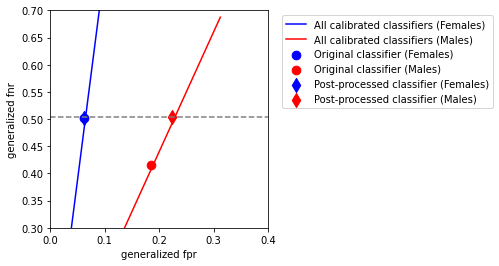

In [19]:
y_pred = postproc.predict_proba(X_test)[:, 1]
y_lr = postproc.estimator_.predict_proba(X_test)[:, 1]
br = postproc.postprocessor_.base_rates_
i = X_test.index.get_level_values('sex') == 1

plt.plot([0, br[0]], [0, 1-br[0]], '-b', label='All calibrated classifiers (Females)')
plt.plot([0, br[1]], [0, 1-br[1]], '-r', label='All calibrated classifiers (Males)')

plt.scatter(generalized_fpr(y_test[~i], y_lr[~i]),
            generalized_fnr(y_test[~i], y_lr[~i]),
            300, c='b', marker='.', label='Original classifier (Females)')
plt.scatter(generalized_fpr(y_test[i], y_lr[i]),
            generalized_fnr(y_test[i], y_lr[i]),
            300, c='r', marker='.', label='Original classifier (Males)')
                                                                        
plt.scatter(generalized_fpr(y_test[~i], y_pred[~i]),
            generalized_fnr(y_test[~i], y_pred[~i]),
            100, c='b', marker='d', label='Post-processed classifier (Females)')
plt.scatter(generalized_fpr(y_test[i], y_pred[i]),
            generalized_fnr(y_test[i], y_pred[i]),
            100, c='r', marker='d', label='Post-processed classifier (Males)')

plt.plot([0, 1], [generalized_fnr(y_test, y_pred)]*2, '--', c='0.5')

plt.axis('square')
plt.xlim([0.0, 0.4])
plt.ylim([0.3, 0.7])
plt.xlabel('generalized fpr');
plt.ylabel('generalized fnr');
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left');

We can see the generalized false negative rate is approximately equalized and the classifiers remain close to the calibration lines.

We can quanitify the discrepancy between protected groups using the `difference` operator:

In [20]:
difference(generalized_fnr, y_test, y_pred, prot_attr='sex')

-0.0006103165829004498